# Identify permitted and potentially unpermitted attached and detached units in San Jose (2020)

In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import math
from tqdm import tqdm

In [2]:
# Import functions for the polygon pipeline
%run ADU_permit_matching-polygon-pipeline.ipynb import (process_OSM_data, \
                                                        compare_buildings, \
                                                        merge_buildings,\
                                                        get_inference_main_building, \
                                                        identify_main_buildings, \
                                                        compute_largest_protruding_poly, \
                                                        compare_building_footprint, \
                                                        flatten_geometries, \
                                                        run_osm_apn, \
                                                        run_osm_apn_full_detail)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# File paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'outputs')
SJ_RES_PARCELS_FP = os.path.join(INPUT_FP, 'inputs', 'san_jose_parcels_res.geojson')
ZONING_FP = os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_Zoning_Districts.geojson')
BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [5]:
# Resources used to display imagery for each parcel
TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

100%|██████████| 3074/3074 [00:00<00:00, 12619.82it/s]


In [6]:
# Load data
# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * Building permits
bldg_active = gpd.read_file(os.path.join(INPUT_FP, 'inputs', 'permits', 'bldg_active.geojson'))
bldg_recent = gpd.read_file(os.path.join(INPUT_FP, 'inputs','permits', 'bldg_recent.geojson'))
bldg_expired = gpd.read_file(os.path.join(INPUT_FP, 'inputs', 'permits', 'bldg_expired.geojson'))

# * Zoning
sj_zoning = gpd.read_file(ZONING_FP)
sj_residential = sj_zoning[(sj_zoning['ZONING'].str.contains('R-1')) | (sj_zoning['ZONING'].str.contains('R-2')) |\
         ((sj_zoning['ZONING'].str.contains('R-M')) & (sj_zoning['ZONING'] != 'R-MH'))]

# * parcel+permit
sj_parcel_permit = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])
sj_permit_noparcel['geometry'] = gpd.GeoSeries.from_wkt(sj_permit_noparcel['geometry'])

Handle active permits differently than expired permits
- Expired permits barely report dwelling units and square footage
- Should we filter really finely like we do for active permits, or filter for just work description as we do for expired permits to catch ALL the construction permits we can find? I worry that some of the buildings we infer will be under non-SFR permits

Keep this block of code in case we want to filter more specifically for possible dwelling units, but we will work with the more relaxed conditions to get more possible permits to compare to

In [7]:
# Filter permits
cols = list(bldg_active.columns) + ['permit_status']
permits = gpd.GeoDataFrame(columns=cols)
for i, status in zip([bldg_active, bldg_recent, bldg_expired], ['active', 'recent', 'expired']):
    i['permit_status'] = status
    permits = pd.concat([permits, i[i['WORKDESC'].isin(['New Construction', 'Additions/Alterations'])]])
permits = permits.reset_index(drop=True)

permits.crs = "EPSG:4326"

# Functions

In [8]:
def match_parcel(parcel_apn):
    # Obtain parcel-level data
    parcel_inputs = parcel_level_data(
      parcel_apn, sj_parcels_res, sj_parcel_permit)
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_inputs

    # Incorporate OSM data
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]
    parcel_buildings, _ = process_OSM_data(
      inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, 
        MIN_AREA_THRESHOLD, FLATTEN_THRESHOLD, parcel_bounds)

    # Incorporate permit data
    parcel_buildings = process_permit_data(parcel_apn, permits_parcel, parcel_buildings)

    return parcel_buildings

In [9]:
def parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit):
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # def mask_buildings(df, parcel_bounds):
    #   df_out = df.sjoin(parcel_bounds[['geometry','geom']])
    #   # print(df_out)
    #   df_out['iou'] = df_out['geometry'].intersection(df_out['geom']).area/df_out['geom'].area
    #   df_out = df_out[df_out['iou'] > 0.7]
    #   return df_out
    
    # Permits
    permits_parcel = sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn]
    if permits_parcel.empty:
        permits_parcels = None

    def mask_buildings1(parcel_bounds, fp):
        df_out = gpd.read_file(fp, mask=parcel_bounds)
        df_out['iou'] = df_out['geometry'].intersection(parcel_bounds).area/df_out['geometry'].area
        df_out = df_out[df_out['iou'] > 0.7]
        if df_out.empty:
            return None
        else:
            return df_out
        
    if len(parcel_bounds['geometry']) == 0:
        return None, None, None, permits_parcels

    inferred_buildings_2020_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2020'))
    inferred_buildings_2016_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2016'))
    osm_buildings_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], OSM_FP)

    return inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel

In [10]:
def process_permit_data(parcel_apn, permits_parcel, parcel_buildings):
    # filter by parcel_buildings in this first pass
    """
    We will only consider non-main buildings OR main buildings with a detected expansion from OSM or 2016.
    
    For each parcel, we will:
    1. Filter for parcels that are clearly not SFRs (has >5 buildings)
    
    There are three types of classifications:
    1. Permitted (building/activity matches to a permit)
        - If expansion, permit needs to be issued between 2015-2020
        - If small building, 
    2. Unpermitted (building/activity doesn't match reasonably to a permit)
    """
    if parcel_buildings is not None:
        if len(parcel_buildings) <= 5:
            # then consider
            parcel_buildings = parcel_buildings[(parcel_buildings['main_building_flag'] == False) | \
                                                ((parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag'])))]
            if not parcel_buildings.empty:
                # then start to do matching
                if permits_parcel is not None and len(permits_parcel) > 0:
                    ## ------ MAIN DRIVER HERE ------
                    output_df = gpd.GeoDataFrame(columns=['apn'] + list(parcel_buildings.columns) + ['verdict', 'permit_id', 'certainty'])
                    permit_nomatch_df = pd.DataFrame(columns=permits_parcel.columns)
                    
                    # then there is a permit matching in that parcel
                    small_building = parcel_buildings[parcel_buildings['main_building_flag'] == False].reset_index(drop=True)
                    expansion = parcel_buildings[(parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag']))].reset_index(drop=True)
                    
                    
                    if not expansion.empty:
                        assert len(expansion) == 1
                        
                        
                    for idx, row in permits_parcel.iterrows():
                        if row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['DWELLINGUNIT'] > 0 and \
                        row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations'):
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                            # then try to find the expansion
                        else:
                            print(row[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'year']])
                            # add to unmatched permits -- probably permits never went through or FN from model
                    
                    # rest is unpermitted
                    if not small_building.empty:
                        small_building['verdict'] = 'unpermitted'
                        small_building['apn'] = parcel_apn
                        output_df = pd.concat([output_df, small_building])
                        
                    if not expansion.empty:
                        expansion['verdict'] = 'unpermitted'
                        expansion['apn'] = parcel_apn
                        output_df = pd.concat([output_df, expansion])
                        
                    return output_df, permit_nomatch_df
#                     if not expansion.empty:
#                         print(expansion)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                        
#                     if not small_building.empty:
#                         print(small_building)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                    
                        
                else:
                    # return all the filtered parcel_buildings, with the caveat that we're highly overestimating
                    parcel_buildings['verdict'] = 'unpermitted'
                    parcel_buildings['apn'] = parcel_apn
                    return parcel_buildings, None
            else:
                # return nothing since we can't consider any of the buildings (at least not rn)
#                 if permits_parcel is not None and len(permits_parcel) > 0:
#                     return None, permits_parcel
#                 else:
#                     return None, None
                return None, None
        else:
            # return nothing since we don't want to consider this parcel
            return None, None
    
#     if len(permits_parcel) > 0:
#         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
#         if parcel_buildings is not None:
#             print(parcel_buildings)
#         else:
#             print(0)
#         pass
#     else:
#         return parcel_buildings

In [11]:
def process_permit_data(parcel_apn, permits_parcel, parcel_buildings):
    # filter by parcel_buildings in this first pass
    """
    We will only consider non-main buildings OR main buildings with a detected expansion from OSM or 2016.
    
    For each parcel, we will:
    1. Filter for parcels that are clearly not SFRs (has >5 buildings)
    
    There are three types of classifications:
    1. Permitted (building/activity matches to a permit)
        - If expansion, permit needs to be issued between 2015-2020
        - If small building, 
    2. Unpermitted (building/activity doesn't match reasonably to a permit)
    """
    if parcel_buildings is not None:
        if len(parcel_buildings) <= 5:
            # then consider
            parcel_buildings = parcel_buildings[(parcel_buildings['main_building_flag'] == False) | \
                                                ((parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag'])))]
            # Non-empty parcel buildings
            if not parcel_buildings.empty:
                # then start to do matching
                if permits_parcel is not None and len(permits_parcel) > 0:
                    ## ------ MAIN DRIVER HERE ------
                    output_df = gpd.GeoDataFrame(columns=['apn'] + list(parcel_buildings.columns) + ['verdict', 'permit_id', 'certainty'])
                    permit_nomatch_df = pd.DataFrame(columns=permits_parcel.columns)
                    
                    # then there is a permit matching in that parcel
                    small_building = parcel_buildings[parcel_buildings['main_building_flag'] == False].reset_index(drop=True)
                    expansion = parcel_buildings[(parcel_buildings['main_building_flag']) & \
                                                 ((parcel_buildings['expansion_OSM_flag']) | \
                                                (parcel_buildings['expansion_2016_flag']))].reset_index(drop=True)
                    
                    
                    if not expansion.empty:
                        assert len(expansion) == 1
                        
                    # Loop over the permits in the parcel 
                    for idx, row in permits_parcel.iterrows():
                        # Main building expansion permits (2015-2020) - positive square footage (higher risk)
                        if row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        # Main building expansion permits (2015-2020) - non-positive square footage (lower risk)
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015 \
                        and row['PERMITVALUE'] > 0:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        # Main building expansion permits (2015-2020) - non-positive square footage and permit value (lowest risk)
                        elif row['WORKDESC'] == 'Additions/Alterations' and row['year'] <= 2020 and row['year'] >= 2015:
                            if not expansion.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        # Other alterations/construction - higher risk for main building
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['DWELLINGUNIT'] > 0 and \
                        row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        #  Other alterations/construction - lower risk for main building
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations') and row['PERMITVALUE'] > 0 and row['SQUAREFOOT'] > 0:
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 2]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                        #  Other alterations/construction - lowest risk for main building
                        elif (row['WORKDESC'] == 'New Construction' or row['WORKDESC'] == 'Additions/Alterations'):
                            if not small_building.empty:
                                output_df.loc[len(output_df)] = [parcel_apn] + small_building.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 3]
                                small_building = small_building.drop(0).reset_index(drop=True)
                            elif not expansion.empty and row['year'] <= 2020 and row['year'] >= 2015:
                                output_df.loc[len(output_df)] = [parcel_apn] + expansion.loc[0].tolist() + ['permitted', row['OBJECTID_left'], 1]
                                expansion.drop(0, inplace=True)
                            else:
                                permit_nomatch_df.loc[len(permit_nomatch_df)] = row.tolist()
                            # then try to find the expansion
                        else:
                            print(row[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'year']])
                            # add to unmatched permits -- probably permits never went through or FN from model
                    
                    # Mark remaining buildings as unpermitted
                    # rest is unpermitted
                    if not small_building.empty:
                        small_building['verdict'] = 'unpermitted'
                        small_building['apn'] = parcel_apn
                        output_df = pd.concat([output_df, small_building])
                        
                    if not expansion.empty:
                        expansion['verdict'] = 'unpermitted'
                        expansion['apn'] = parcel_apn
                        output_df = pd.concat([output_df, expansion])
                        
                    return output_df, permit_nomatch_df
#                     if not expansion.empty:
#                         print(expansion)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                        
#                     if not small_building.empty:
#                         print(small_building)
#                         print(permits_parcel[['WORKDESC', 'SUBDESC', 'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM']])
                    
                # Empty permits        
                else:
                    # return all the filtered parcel_buildings, with the caveat that we're highly overestimating
                    parcel_buildings['verdict'] = 'unpermitted'
                    parcel_buildings['apn'] = parcel_apn
                    return parcel_buildings, None
                
            # Empty buildings
            else:
                # return nothing since we can't consider any of the buildings (at least not rn)
                return None, None

        # Non-residential parcel (>5 buildings)
        else:
            # return nothing since we don't want to consider this parcel
            return None, None

# Main

In [23]:
if os.path.exists('shortlist.csv'):
    shortlist = pd.read_csv('shortlist.csv')
else:
    shortlist = pd.DataFrame(columns=['apn', 'main_building_flag', 'OSM_flag', 
                                      'expansion_OSM_flag', 'expansion_2016_flag', 
                                      'geometry', 'verdict', 'permit_id', 'certainty'])
    
if os.path.exists('permit_nomatch.csv'):
    permit_nomatch = pd.read_csv('permit_nomatch.csv')
else:
    permit_nomatch = pd.DataFrame()

In [41]:
# Loop over each parcel
parcel_apns = sj_parcels_res['APN'].unique()

idx = 0
for parcel_apn in tqdm(parcel_apns):
    # Run the condition below if you want to filter only on permits that match to a parcel
#    if not sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn].empty:
    shortlist_parcel, permit_nomatch_df = match_parcel(parcel_apn)
    if shortlist_parcel is not None and len(shortlist_parcel) > 0:
        shortlist = pd.concat([shortlist, shortlist_parcel])
    if permit_nomatch_df is not None and len(permit_nomatch_df) > 0:
        permit_nomatch = pd.concat([permit_nomatch, permit_nomatch_df]) 
    idx += 1
    if idx % 100 == 0:
        shortlist.to_csv('shortlist.csv', index=False)
        permit_nomatch.to_csv('permit_nomatch.csv', index=False)

100%|██████████| 100/100 [05:54<00:00,  3.55s/it]


## Balanced sampling over parcels
Second pass and third pass of the parcel-level results as described in the Building Compliance Pre-Reads document

In [14]:
def load_data_dict(pass_id):
    
    data_dict = {
        'perm_shortlist': pd.DataFrame(columns=shortlist_cols), 
        'unperm_shortlist': pd.DataFrame(columns=shortlist_cols),
        'perm_permit_nomatch': pd.DataFrame(columns=sj_parcel_permit.columns),
        'unperm_permit_nomatch': pd.DataFrame(columns=sj_parcel_permit.columns)
    }
    
    pass_output_path = os.path.join(OUTPUT_FP, 'shortlists', 'Pass_{}'.format(pass_id))
    path_dict = {key: os.path.join(pass_output_path, '{}.csv'.format(key)) for key in data_dict.keys()}

    
    for key, df in data_dict.items():
        if os.path.exists(path_dict[key]):
            try:
                data = pd.read_csv(path_dict[key]) 
            except pd.errors.EmptyDataError:
                data = df
            data_dict[key] = data
    return data_dict, path_dict

In [15]:
MIN_AREA_THRESHOLD = 30
FLATTEN_THRESHOLD = 0.85
SAMPLE_SIZE = 1000
PASS = 3

assert PASS in [2, 3]

In [22]:
# Set up parcels that match and don't match to permits
shortlist_cols = ['apn', 'main_building_flag', 'OSM_flag', 'expansion_OSM_flag', 
                  'expansion_2016_flag', 'geometry', 'verdict', 'permit_id', 'certainty']

# Check progress
data_dict, path_dict = load_data_dict(pass_id=PASS)
    
reviewed_perm_apns = set(data_dict['perm_shortlist']['apn'].unique()) 
#reviewed_perm_apns = reviewed_perm_apns.union(
#    set(data_dict['perm_permit_nomatch']['APN_parcel'].unique()))

reviewed_unperm_apns = set(data_dict['unperm_shortlist']['apn'].unique())
#reviewed_unperm_apns = reviewed_unperm_apns.union(
#    set(data_dict['unperm_permit_nomatch']['APN_parcel'].unique()))

# Set up parcels to sample
if PASS == 2:
    parcel_apns = sj_parcels_res['APN'].unique()
    np.random.seed(43)
    parcel_apns = np.random.choice(parcel_apns, len(parcel_apns), replace=False)
elif PASS == 3:
    # For third pass, we look over the same parcels from the second pass for comparison purposes
    P2_perm_shortlist = pd.read_csv(
        os.path.join(OUTPUT_FP, 'shortlists', 'Pass_2', 'perm_shortlist.csv'))
    P2_unperm_shortlist = pd.read_csv(
        os.path.join(OUTPUT_FP, 'shortlists', 'Pass_2', 'unperm_shortlist.csv'))
    P2_perm_permit_nomatch = pd.read_csv(
        os.path.join(OUTPUT_FP, 'shortlists', 'Pass_2', 'perm_permit_nomatch.csv'))
    P2_unperm_permit_nomatch = pd.read_csv(
        os.path.join(OUTPUT_FP, 'shortlists', 'Pass_2', 'unperm_permit_nomatch.csv'))
    
    parcel_apns = list(P2_perm_shortlist['apn'].unique())
    parcel_apns = parcel_apns + list(P2_unperm_shortlist['apn'].unique())
    parcel_apns = parcel_apns + list(P2_perm_permit_nomatch['APN_parcel'].unique())
    parcel_apns = parcel_apns + list(P2_unperm_permit_nomatch['APN_parcel'].unique())

print('Reviewed permitted APNs: {}; Reviewed unpermitted APNs: {}'.format(len(reviewed_perm_apns), len(reviewed_unperm_apns)))
reviewed_apns = list(reviewed_perm_apns) + list(reviewed_unperm_apns)

Reviewed permitted APNs: 1000; Reviewed unpermitted APNs: 1000


In [23]:
# Loop over sampled parcels
for i, parcel_apn in tqdm(enumerate(parcel_apns)):
    if parcel_apn in reviewed_apns:
        continue
    
    count_perm = len(data_dict['perm_shortlist']['apn'].unique())
    count_unperm = len(data_dict['unperm_shortlist']['apn'].unique())
        
    #if count_perm >= SAMPLE_SIZE and count_unperm >= SAMPLE_SIZE:
    #    break
    
    # Filter only on permits that match to a parcel
    if not sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn].empty:
        #if count_perm < SAMPLE_SIZE:
        if True:
            shortlist_parcel, permit_nomatch_df = match_parcel(parcel_apn)
            if shortlist_parcel is None:
                shortlist_parcel = pd.DataFrame.from_dict(
                    {col: [None] for col in data_dict['perm_shortlist'].columns})
                shortlist_parcel['apn'] = parcel_apn
            temp = pd.concat([data_dict['perm_shortlist'], shortlist_parcel])
            data_dict['perm_shortlist'] = temp
                
            if permit_nomatch_df is not None and len(permit_nomatch_df) > 0:
                temp = pd.concat([data_dict['perm_permit_nomatch'], permit_nomatch_df])
                data_dict['perm_permit_nomatch'] = temp
        else:
            continue
    else:
        #if count_unperm < SAMPLE_SIZE:
        if True:
            shortlist_parcel, permit_nomatch_df = match_parcel(parcel_apn)
            if shortlist_parcel is None:
                shortlist_parcel = pd.DataFrame.from_dict(
                    {col: [None] for col in data_dict['unperm_shortlist'].columns})
                shortlist_parcel['apn'] = parcel_apn
            temp = pd.concat([ data_dict['unperm_shortlist'], shortlist_parcel])
            data_dict['unperm_shortlist'] = temp
            
            if permit_nomatch_df is not None and len(permit_nomatch_df) > 0:
                temp = pd.concat([data_dict['unperm_permit_nomatch'], permit_nomatch_df])
                data_dict['unperm_permit_nomatch'] = temp      
        else:
            continue

    
    if i % 50 == 0:
        count_perm = len(data_dict['perm_shortlist']['apn'].unique())
        count_unperm = len(data_dict['unperm_shortlist']['apn'].unique())
        
        print("Permitted: {}; Unpermitted: {}".format(count_perm, count_unperm))
        
        for key, df in data_dict.items():
            df.to_csv(path_dict[key], index=False)

        data_dict, path_dict = load_data_dict(pass_id=PASS)
        
        count_perm = len(data_dict['perm_shortlist']['apn'].unique())
        count_unperm = len(data_dict['unperm_shortlist']['apn'].unique())
        
        print("Saved Permitted: {}; Unpermitted: {}".format(count_perm, count_unperm))

print("Permitted: {}; Unpermitted: {}".format(count_perm, count_unperm))
for key, df in data_dict.items():
    df.to_csv(path_dict[key], index=False)

2409it [00:35, 68.25it/s]


Permitted: 1000; Unpermitted: 1006


## Explore sampled parcel results

In [26]:
# Read in data
data_dict, path_dict = load_data_dict(pass_id=PASS)

perm_shortlist = data_dict['perm_shortlist'].copy()
unperm_shortlist = data_dict['unperm_shortlist'].copy()
perm_permit_nomatch = data_dict['perm_permit_nomatch'].copy()
unperm_permit_nomatch = data_dict['unperm_permit_nomatch'].copy()

# Ensure we have the same parcel APNS as round 2 so that results are comparable
if PASS == 3:
    P2_perm_parcels = set(P2_perm_shortlist['apn'].unique())
    P2_perm_parcels = P2_perm_parcels.union(set(P2_perm_permit_nomatch['APN_parcel'].unique()))
    
    P2_unperm_parcels = set(P2_unperm_shortlist['apn'].unique())
    P2_unperm_parcels = P2_unperm_parcels.union(set(P2_unperm_permit_nomatch['APN_parcel'].unique()))
    
    perm_shortlist = perm_shortlist.loc[perm_shortlist['apn'].isin(P2_perm_parcels)]
    unperm_shortlist = unperm_shortlist.loc[unperm_shortlist['apn'].isin(P2_unperm_parcels)]
    
    P2_perm_nomatch_parcels = perm_permit_nomatch['APN_parcel'].unique()
    P2_unperm_nomatch_parcels = unperm_permit_nomatch['APN_parcel'].unique()
    
    perm_permit_nomatch = perm_permit_nomatch.loc[perm_permit_nomatch['APN_parcel'].isin(P2_perm_nomatch_parcels)]
    unperm_permit_nomatch = unperm_permit_nomatch.loc[unperm_permit_nomatch['APN_parcel'].isin(P2_unperm_nomatch_parcels)]
    
    assert len(perm_shortlist['apn'].unique()) == SAMPLE_SIZE
    assert len(unperm_shortlist['apn'].unique()) == SAMPLE_SIZE
    
# Drop parcels with no events of interest
# Note: this ensures that we've covered a random sample of 1000 parcels, 
# regardless of whether we saw an event of interest in a parcel
perm_shortlist = perm_shortlist.loc[perm_shortlist['main_building_flag'].notnull()]
unperm_shortlist = unperm_shortlist.loc[unperm_shortlist['main_building_flag'].notnull()]

print(len(perm_shortlist['apn'].unique()))
print(len(unperm_shortlist['apn'].unique()))

702
606


In [27]:
# Grab first SAMPLE_SIZE parcels of each type
perm_shortlist['shortlist_type'] = 'permitted'
unperm_shortlist['shortlist_type'] = 'unpermitted'

perm_permit_nomatch['shortlist_type'] = 'permitted'
unperm_permit_nomatch['shortlist_type'] = 'unpermitted'

#perm_apns = perm_shortlist['apn'].unique()
#perm_apns = np.random.choice(perm_apns, size=SAMPLE_SIZE, replace=False)

#unperm_apns = unperm_shortlist['apn'].unique()
#unperm_apns = np.random.choice(unperm_apns, size=SAMPLE_SIZE, replace=False)

shortlist = pd.concat([perm_shortlist, unperm_shortlist])

permit_nomatch = pd.concat([perm_permit_nomatch, unperm_permit_nomatch])

# Drop duplicate geometries
permit_nomatch = permit_nomatch.drop_duplicates()
shortlist = shortlist.drop_duplicates()

In [28]:
# Compute stats
shortlist['expansion_flag'] = shortlist['expansion_2016_flag'] | shortlist['expansion_OSM_flag']
shortlist.groupby(['shortlist_type', 'verdict', 'main_building_flag', 'expansion_2016_flag'])['apn'].count()

shortlist_type  verdict      main_building_flag  expansion_2016_flag
permitted       permitted    False               False                  223
                                                 True                   164
                             True                False                   24
                                                 True                    91
                unpermitted  False               False                  116
                                                 True                   164
                             True                False                   44
                                                 True                    89
unpermitted     unpermitted  False               False                  273
                                                 True                   223
                             True                False                   74
                                                 True                   142
Name: apn, dtype: i

In [29]:
permit_nomatch.groupby(['shortlist_type'])['APN_parcel'].count()

shortlist_type
permitted    348
Name: APN_parcel, dtype: int64

In [55]:
permit_nomatch = permit_nomatch.drop_duplicates()

In [71]:
# Look at unmatched permits
# Filter for permits after 2015
permit_nomatch_16_20 = permit_nomatch.loc[(permit_nomatch['year'] >= 2016) & (permit_nomatch['year'] <= 2020)]

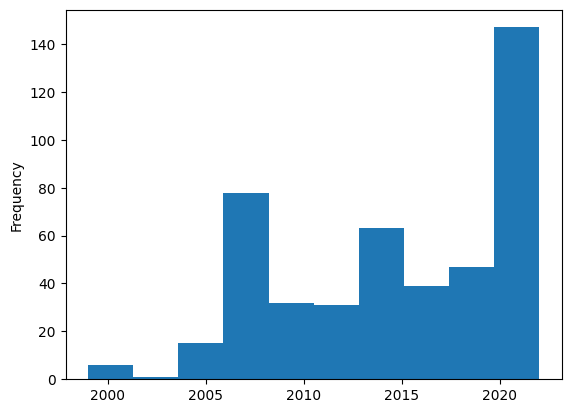

In [68]:
permit_nomatch['year'].plot.hist()
plt.show()

In [72]:
len(permit_nomatch_16_20)

94

In [78]:
permit_nomatch_16_20.iloc[1]

In [76]:
sj_parcel_permit[sj_parcel_permit['APN_parcel'] == '27406055'][[
    'OBJECTID_left', 'WORKDESC', 'SUBDESC', 'FOLDERNUM', 'permit_status', 'PERMITVALUE',
    'DWELLINGUNIT', 'SQUAREFOOT']]

,OBJECTID_left,WORKDESC,SUBDESC,FOLDERNUM,permit_status,PERMITVALUE,DWELLINGUNIT,SQUAREFOOT
11477,E_42433,Additions/Alterations,Single-Family,2018-135213-RS,expired,1224.0,0,0
11848,E_45244,Additions/Alterations,Single-Family,2018-114830-RS,expired,25616.0,0,0


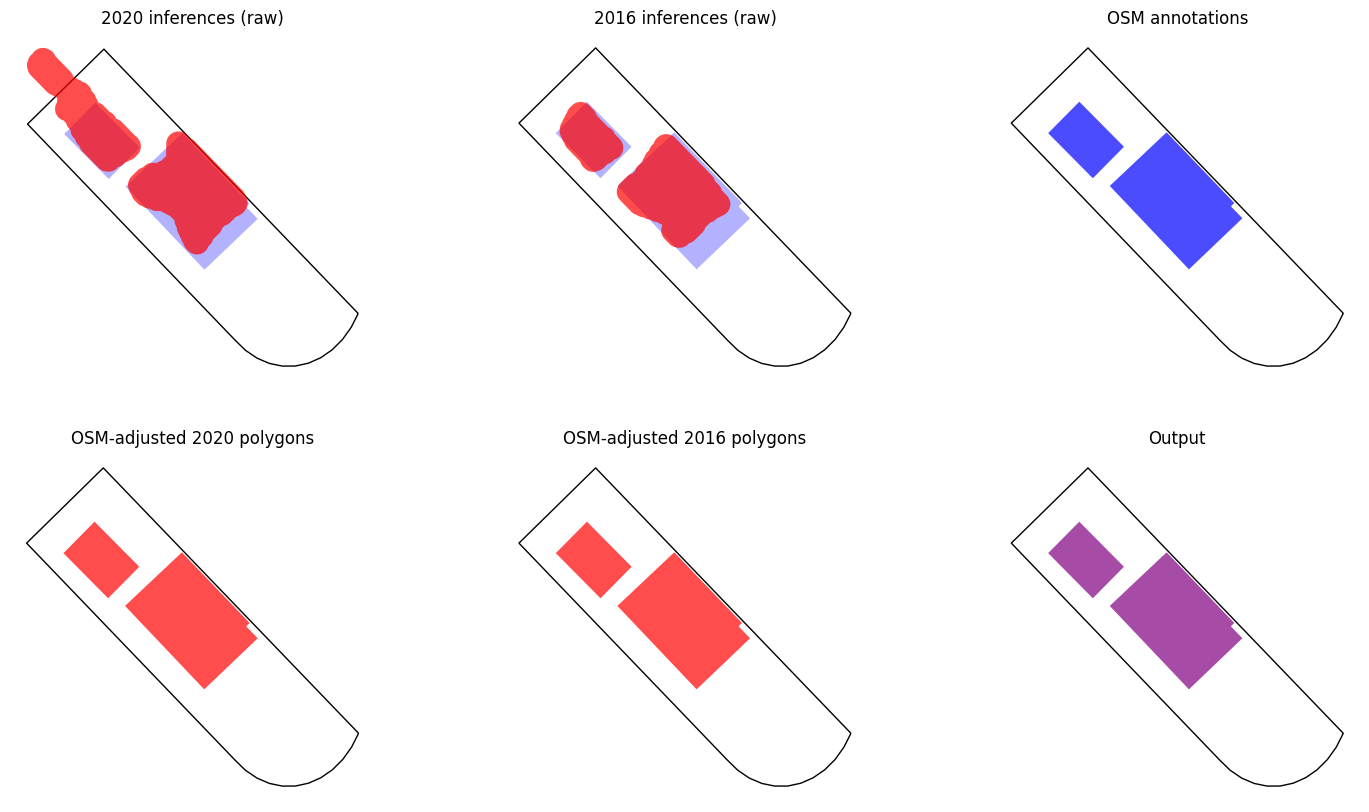

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,area
0,True,True,False,True,"POLYGON ((-121.93138 37.33552, -121.93129 37.3...",152.201468
1,False,True,False,False,"POLYGON ((-121.93147 37.33558, -121.93142 37.3...",47.968386


In [34]:
run_osm_apn_full_detail(parcel_apn='27406055', area_threshold=30, flatten_threshold=0.80)

In [66]:
# Look at small building constructions -- are these mostly false positives?
sb_parcels = list(shortlist.loc[(shortlist['main_building_flag'] == False) & (shortlist['expansion_2016_flag'] == True)]['apn'].unique())
np.random.seed(42)
np.random.choice(sb_parcels, size=20, replace=False)

array(['47701057', '44249007', '40306200', '09218018', '68517068',
       '67837030', '46742046', '27725060', '28822023', '26434063',
       '48625083', '44213023', '23020031', '27447043', '59209020',
       '69414018', '26440053', '43402072', '49145030', '56749057'],
      dtype='<U8')

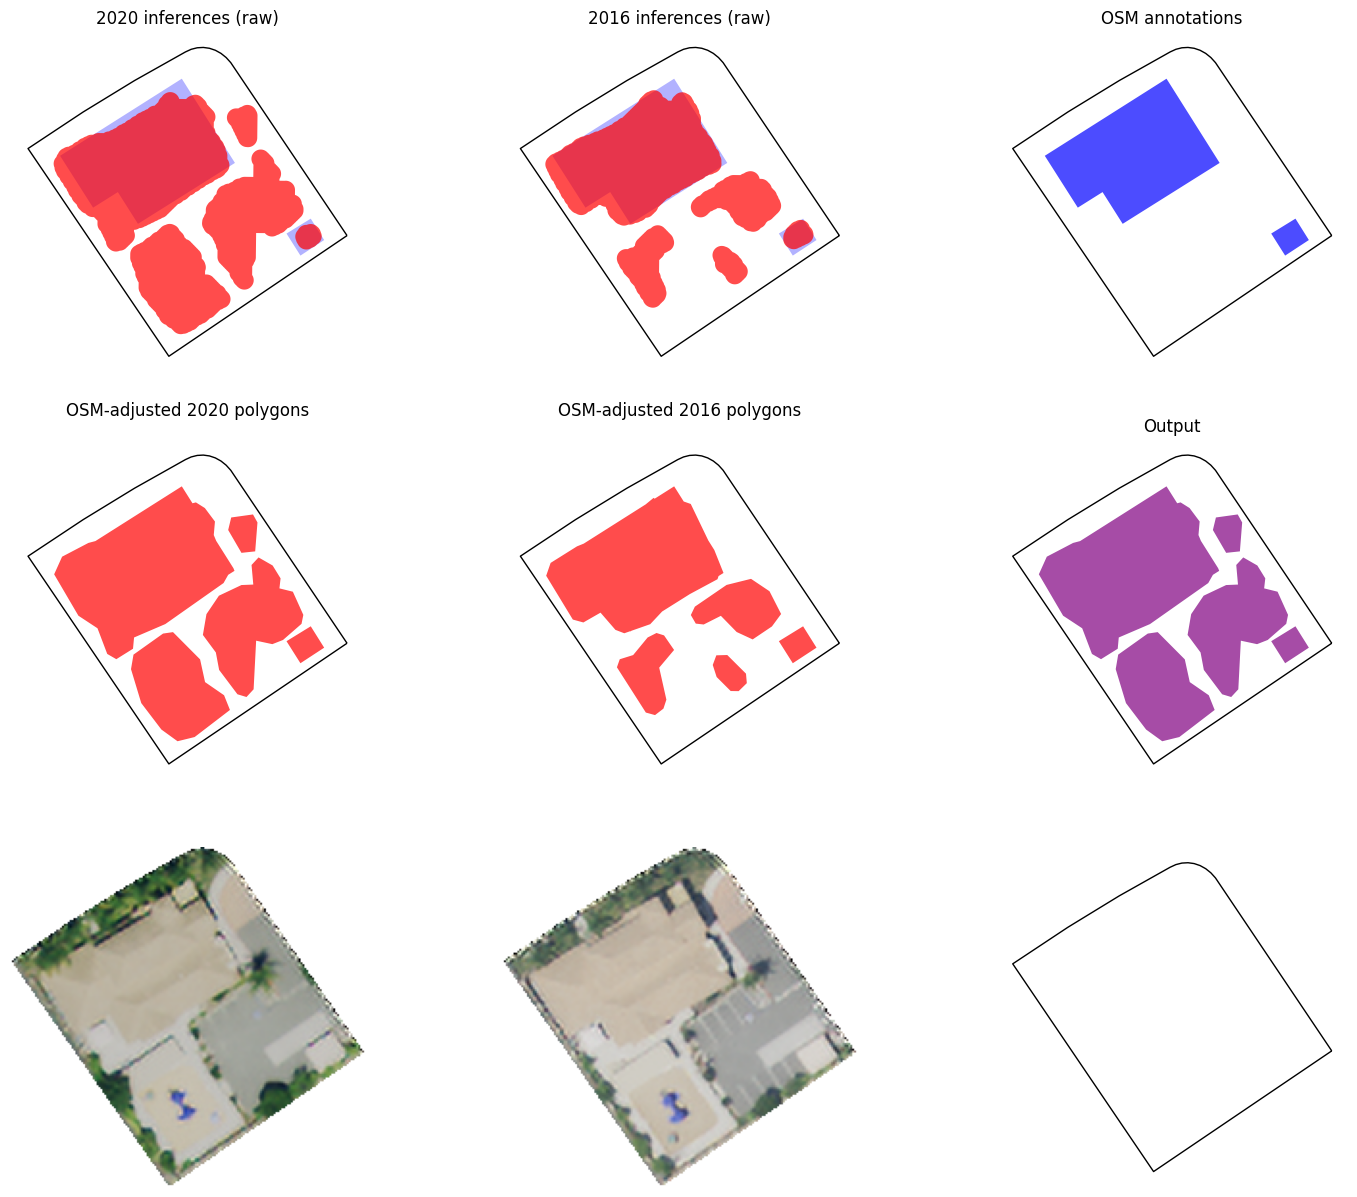

,main_building_flag,OSM_flag,expansion_OSM_flag,diff_OSM_value,expansion_2016_flag,diff_2016_value,geometry,area
1,False,True,False,0.0,False,0.0,"POLYGON ((-121.88165 37.24823, -121.88162 37.2...",21.458360
0,True,False,True,82.586285,True,40.587859,"POLYGON ((-121.88182 37.24830, -121.88193 37.2...",487.677483
2,False,False,True,207.517281,True,76.99282,"POLYGON ((-121.88186 37.24822, -121.88185 37.2...",207.517281
3,False,False,True,191.026291,True,111.916843,"POLYGON ((-121.88200 37.24817, -121.88199 37.2...",191.026291
4,False,False,True,24.94935,True,24.94935,"POLYGON ((-121.88181 37.24838, -121.88180 37.2...",24.949350


In [91]:
#run_osm_apn_full_detail(
#    parcel_apn='23020031', area_threshold=30, flatten_threshold=0.85, 
#    sat_imagery=None)

run_osm_apn_full_detail(
    parcel_apn='56749057', area_threshold=30, flatten_threshold=0.85, 
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res, 'tiles_gdf': tiles_gdf})

In [37]:
# Look at main building expansions
mb_parcels = list(shortlist.loc[(shortlist['main_building_flag'] == True)]['apn'].unique())
np.random.seed(42)
np.random.choice(mb_parcels, size=20, replace=False)

array(['38124030', '57535014', '42950017', '43933025', '65404030',
       '41940113', '47223011', '48608012', '70845021', '26140107',
       '48809009', '70165005', '46257003', '59212043', '27415073',
       '26455029', '61234014', '47735002', '48632031', '41933001'],
      dtype='<U8')

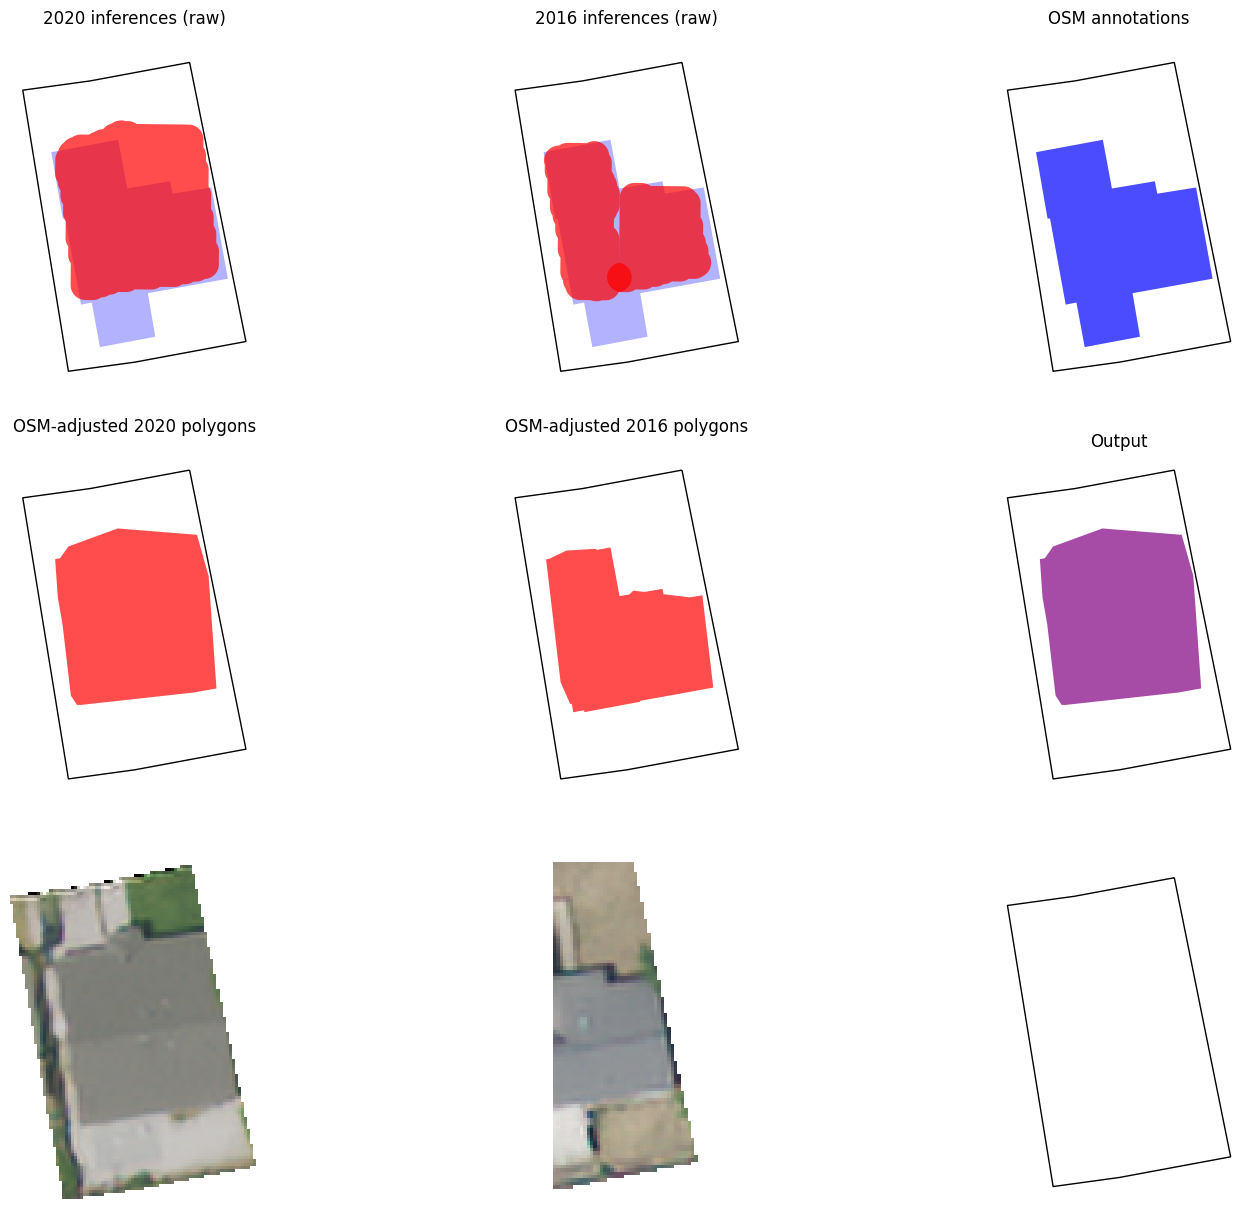

,main_building_flag,OSM_flag,expansion_OSM_flag,diff_OSM_value,expansion_2016_flag,diff_2016_value,geometry,area
0,True,False,True,69.214331,True,65.310263,"POLYGON ((-121.92894 37.24626, -121.92893 37.2...",277.014752


In [63]:
run_osm_apn_full_detail(
    parcel_apn='41933001', area_threshold=30, flatten_threshold=0.85, 
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res, 'tiles_gdf': tiles_gdf})

In [26]:
# Check
#parcel_apn='48114037'
#inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
#parcel_buildings = process_OSM_data(
#    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel)

In [2]:
# 3.5 Sort shortlists
# TO DO
# Risk levels:
# highest risk, no permitted additions of any kind, and you detect detached
# no permitted additions of any kind, and you detect attached
# permitted detached ADU, you detect more than one detached
# permitted detached ADU, you detect attached and detached
# permitted attached ADU, you detect attached and detached
# permitted attached ADU, you detect a detached (or vice versa)
# permitted attached ADU and detached ADU, you detect anything unpermitted

## Check Pass 3 changes

In [66]:
# Check parcels in Pass 2 but not 3

In [71]:
dropped_buildings = P2_perm_shortlist.loc[~P2_perm_shortlist['apn'].isin(perm_shortlist['apn'].unique())]

In [72]:
# Small buildings
dropped_buildings.loc[dropped_buildings['main_building_flag'] == False]

,apn,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,verdict,permit_id,certainty,area,shortlist_type
28,42116035,False,False,True,True,POLYGON ((-121.9411554302895 37.24776010280727...,permitted,A_60084,3.0,43.869925,permitted
47,68932067,False,False,True,True,POLYGON ((-121.8063718901103 37.23213528351648...,permitted,A_96351,3.0,19.499806,permitted
55,26454068,False,False,True,NaN,POLYGON ((-121.9015283596802 37.31188006849541...,permitted,E_52615,3.0,25.493336,permitted
60,48625083,False,False,True,False,POLYGON ((-121.8303315458205 37.34042271097121...,permitted,A_56160,3.0,33.200165,permitted
61,48625083,False,False,True,True,POLYGON ((-121.8300556017206 37.34030911719219...,unpermitted,NaN,NaN,16.027336,permitted
...,...,...,...,...,...,...,...,...,...,...,...
2166,43411016,False,False,True,False,POLYGON ((-121.8804754781149 37.31544661537133...,permitted,E_856,3.0,29.067590,NaN
2177,67016039,False,False,True,False,POLYGON ((-121.8120997950016 37.31142097633292...,unpermitted,NaN,NaN,22.637683,NaN
2186,58627003,False,False,True,True,POLYGON ((-121.8638959518364 37.40375885638167...,unpermitted,NaN,NaN,20.627758,NaN
2210,23508029,False,False,True,True,"POLYGON ((-121.9012134450022 37.3548736107065,...",unpermitted,NaN,NaN,34.924428,NaN


In [73]:
# Main building expansions
dropped_buildings.loc[dropped_buildings['main_building_flag'] == True]

,apn,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry,verdict,permit_id,certainty,area,shortlist_type
17,44710075,True,True,False,True,"POLYGON ((-121.916835 37.267641, -121.916842 3...",unpermitted,NaN,NaN,201.121077,permitted
22,57535009,True,True,False,True,"POLYGON ((-121.888255 37.22096, -121.888158 37...",permitted,E_36155,3.0,176.063897,permitted
26,37218003,True,True,False,True,"POLYGON ((-122.026936 37.297518, -122.026878 3...",unpermitted,NaN,NaN,248.768632,permitted
27,43944074,True,True,False,True,"POLYGON ((-121.888387 37.276904, -121.888405 3...",unpermitted,NaN,NaN,246.045841,permitted
29,42116035,True,True,False,True,"POLYGON ((-121.941429 37.24766699999999, -121....",unpermitted,NaN,NaN,269.904643,permitted
...,...,...,...,...,...,...,...,...,...,...,...
2208,69018C77,True,True,False,True,"POLYGON ((-121.822735 37.254454, -121.822635 3...",unpermitted,NaN,NaN,276.630891,NaN
2209,23508029,True,True,False,True,"POLYGON ((-121.90112 37.35470099999999, -121.9...",permitted,E_51273,3.0,121.322286,NaN
2212,24526077,True,False,True,True,POLYGON ((-121.8791540929001 37.38433116094873...,unpermitted,NaN,NaN,274.129292,NaN
2218,64708044,True,True,False,True,"POLYGON ((-121.810084 37.358401, -121.81009 37...",permitted,E_46133,3.0,208.945166,NaN


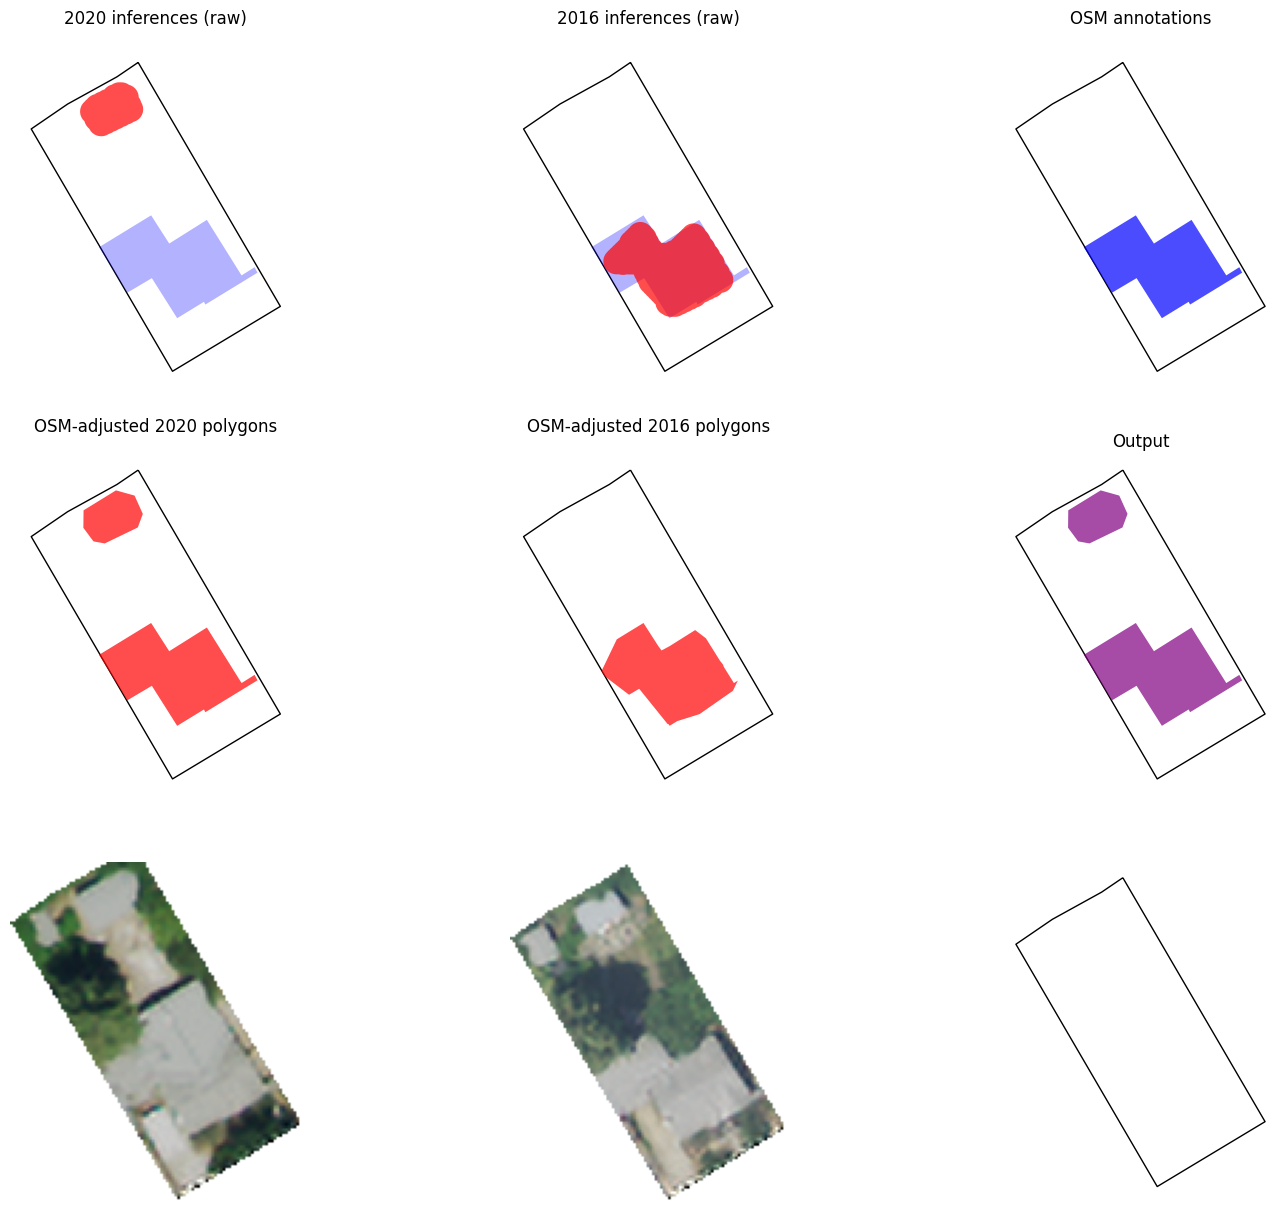

,main_building_flag,OSM_flag,expansion_OSM_flag,diff_OSM_value,expansion_2016_flag,diff_2016_value,geometry,area
0,True,True,False,0.0,False,3.610861,"POLYGON ((-121.90112 37.35470, -121.90115 37.3...",121.322286
1,False,False,True,32.524614,True,32.524614,"POLYGON ((-121.90121 37.35487, -121.90121 37.3...",32.524614


In [13]:
run_osm_apn_full_detail(
    parcel_apn='23508029', area_threshold=30, flatten_threshold=0.85, 
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res, 'tiles_gdf': tiles_gdf})